# Statistical significance of overlap

* We observe 4 genes predicted as targets Mir-197 and down-regulated in response to its overexpression
* Is this more than we would expect to see by chance?

# Load data

In [1]:
from rodent_loss_src.doapr import read_and_filter_doapr
from pathlib import Path
import pandas as pd

ORGANISMS = ["human", "mouse"]
MIRNAS = ["mir197", "mir769"]
PROJECTDIR = Path('.').resolve().parents[2]


tarpath = f'{PROJECTDIR}/milestones/data/doapr/sigdown_and_predictedTargets_tsM_tsH.tsv'
oma_path = f'{PROJECTDIR}/analyses/rnaseq/data/human_mouse_omapairwise.txt'

col = []
for organism in ORGANISMS:
    for mirna in MIRNAS:
        condition = f'{organism}|{mirna}'
        targetdf = read_and_filter_doapr(tarpath, organism, mirna, targetscan_cutoff=-0.2)
        doapr = [gene.upper() for gene in targetdf.index]
        col.append([condition, len(set(doapr))])

condition_doApr = pd.DataFrame(col, columns=['condition', 'num_doApr'])
display(condition_doApr)

,condition,num_doApr
0,human|mir197,25
1,human|mir769,24
2,mouse|mir197,20
3,mouse|mir769,17


## Simluation-based approach

* Draw random sets of size "down and predicted" from all genes expressed in iPSCs
* enumerate overlap

In [2]:
from rodent_loss_src.rnaseq import read_oma, parse_rnaseq, find_significant


def expressed_genes(df, min_base=100):
    df = df[df.baseMean >= min_base]
    return set(df.gene.str.upper())



pairwise = read_oma(oma_path)
condition2all_genes = {}
for organism in ORGANISMS:
    
    
    for mirna in MIRNAS:
        condition = f'{organism}|{mirna}'
        rnaseqdf = parse_rnaseq(f'{PROJECTDIR}/analyses/rnaseq/data/{organism}_results_Neg_vs_{mirna}.tsv', pairwise, organism, mirna)
        all_genes = expressed_genes(rnaseqdf)
        condition2all_genes[condition] = all_genes
        


    

In [12]:
import random as rd

def sample_overlap(condition2all_genes, condition_doApr, con1='human|mir197', con2='mouse|mir197', iterations=1000000):
    overlap_count = []
    con1_k = condition_doApr.num_doApr[condition_doApr.condition == con1].values[0]
    con2_k = condition_doApr.num_doApr[condition_doApr.condition == con2].values[0]

    con1_genes = sorted(condition2all_genes[con1])
    con2_genes = sorted(condition2all_genes[con2])
    
    for i in range(iterations):
        random_subset_con1 = set(rd.sample(con1_genes, k=con1_k))
        random_subset_con2 = set(rd.sample(con2_genes, k=con2_k))

        overlap = random_subset_con1.intersection(random_subset_con2)
        overlap_count.append(len(overlap))
    return overlap_count
    


random_overlap = sample_overlap(condition2all_genes, condition_doApr)

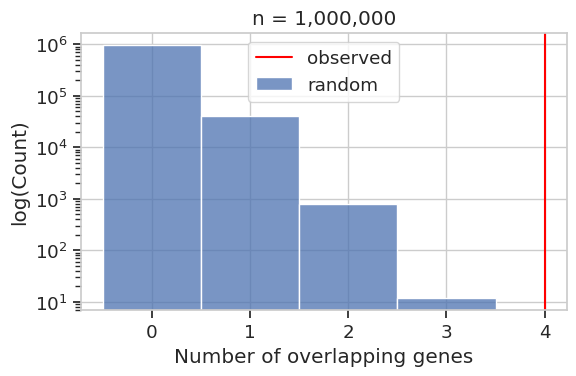

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(6,4), 'ytick.left': True, 'xtick.bottom': True}, font_scale = 1.2, style='whitegrid')
sns.histplot(random_overlap, discrete=True, label='random')
plt.axvline(4, color='red', label='observed')
plt.legend()
plt.yscale('log')
plt.ylabel('log(Count)')
plt.xlabel('Number of overlapping genes')
plt.title('n = 1,000,000')
plt.tight_layout()
plt.savefig(f'{PROJECTDIR}/publication/revision/overlap_simulation.pdf')
plt.show()

## Fisher's exact test

M = total options
n = number positive outcomes
N = sample size
x = number of sucessfull draws

In [5]:
from scipy.stats import hypergeom


def hypergeometric_overlap(condition2all_genes, condition_doApr, condition, inverse_condition):

    N = condition_doApr.num_doApr[condition_doApr.condition == condition].values[0]
    n = condition_doApr.num_doApr[condition_doApr.condition == inverse_condition].values[0]
    M = len(condition2all_genes[condition])  
    x = 4

    print(x, M, n, N)
    pval = hypergeom.sf(x, M, n, N)
    
    expected_draws = (N*n)/M
    
    fold_enrichment = x / expected_draws
    
    print(f'{fold_enrichment:.2f} enrichment with p-value {pval:.1e}')


hypergeometric_overlap(condition2all_genes, condition_doApr, condition='human|mir197', inverse_condition='mouse|mir197')
hypergeometric_overlap(condition2all_genes, condition_doApr, condition='mouse|mir197', inverse_condition='human|mir197')

4 9402 20 25
75.22 enrichment with p-value 1.3e-09
4 8465 25 20
67.72 enrichment with p-value 2.2e-09
